In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 150)

import gc
import os

# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

root = '../instacart_data_files/'


In [2]:
aisles = pd.read_csv(root + 'aisles.csv')
departments = pd.read_csv(root + 'departments.csv')
orders = pd.read_csv(root + 'orders.csv')
order_products_prior = pd.read_csv(root + 'order_products__prior.csv')
order_products_train = pd.read_csv(root + 'order_products__train.csv')
products = pd.read_csv(root + 'products.csv')


In [3]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape


(32434489, 15)

In [4]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [5]:
print("Since there are thousands of products in the dataset I will rely on aisles, which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier.")

Since there are thousands of products in the dataset I will rely on aisles, which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier.


In [6]:
cross_df = pd.crosstab(order_products['user_id'], order_products['aisle'])
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,8,0,0,0,0,0,2,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,9,33,0,0,0,0,1,0,0,0,12,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,10,0,0,0,0,0,0,0,3,0,1,0,0,5,0,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,5,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,5,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,1,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [7]:
print("I will normalize each row")

I will normalize each row


In [8]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.016949,0.0,0.000000,0.0,0.000000,0.0,0.050847,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.033898,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.084746,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.152542,0.000000,0.000000,0.0,0.000000,0.135593,0.0,0.000000,0.0,0.0,0.000000,0.033898,0.0,0.000000,0.000000,0.203390,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.220339,0.000000,0.033898,0.0,0.000000,0.0,0.0,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,0.0,0.005128,0.005128,0.010256,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.005128,0.0,0.000000,0.061538,0.0,0.0,0.0,0.0,0.025641,0.0,0.056410,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.030769,0.0,0.0,0.0,0.0,0.0,0.0,0.046154,0.169231,0.000000,0.000000,0.000000,0.0,0.005128,0.000000,0.0,0.0,0.061538,0.0,0.0,0.0,0.020513,0.0,0.0,0.005128,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.005128,0.0,0.0,0.0,0.0,0.051282,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.015385,0.000000,0.005128,0.0,0.000000,0.025641,0.0,0.005128,0.0,0.0,0.015385,0.000000,0.0,0.005128,0.000000,0.051282,0.0,0.000000,0.005128,0.0,0.0,0.000000,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.005128,0.0,0.000000,0.0,0.0,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.

In [9]:
df.shape

(206209, 134)

In [10]:
#PCA and K-Means Clustering
#Reducing this dataframe to only 10 dimensions as KMeans does not work properly in higher dimension.

In [11]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018865,-0.088343,-0.104542,-0.116443,0.083802,-0.062455,-0.026040
1,-0.036988,0.108884,-0.066406,-0.123271,0.098849,-0.033947,-0.054729,-0.053379,-0.020699,-0.008065
2,0.064282,0.103962,0.000710,-0.012221,-0.046984,0.112254,-0.029805,0.007826,0.011703,0.001957
3,-0.093210,0.054093,0.001867,-0.003974,-0.071355,-0.019283,-0.025107,-0.038234,0.006448,-0.000674
4,0.094629,-0.037051,-0.024952,-0.021575,0.055368,0.107650,-0.008036,0.103910,0.051635,-0.025822


In [12]:
Sum_of_squared_distances = []
K = range(1,10)
for k in range(1,10):
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)
Sum_of_squared_distances

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:8

[9034.695259369262,
 7469.623823184236,
 6629.157523260662,
 5934.960506053375,
 5393.399660031515,
 5034.303723501415,
 4718.9488643517325,
 4493.313619026403,
 4238.648626860045]

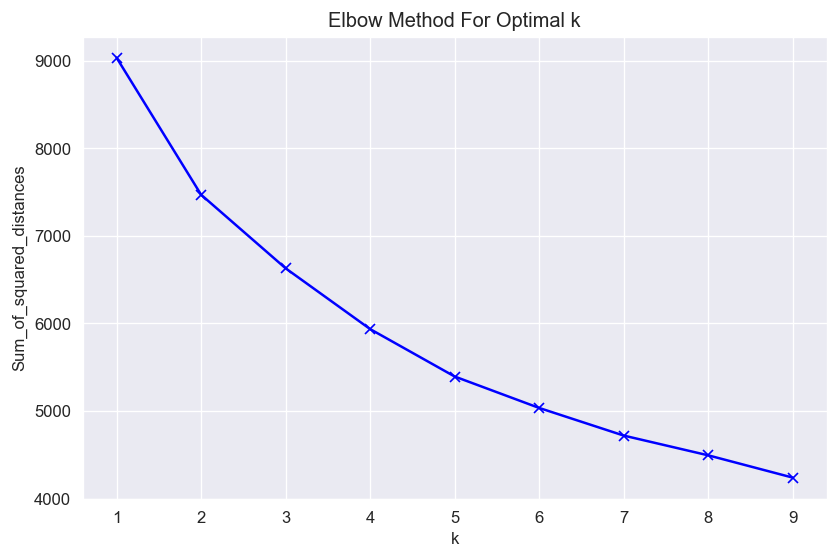

In [13]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [14]:
print("From above plot we can choose optimal K as 5")

From above plot we can choose optimal K as 5


In [15]:
clusterer = KMeans(n_clusters=5,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[ 6.68041288e-02  1.04328187e-01 -1.37198865e-03 -3.09056461e-02
  -1.03207663e-02  7.48006260e-03 -6.03187985e-04  4.55451867e-03
  -7.46358673e-04 -1.64209901e-04]
 [ 1.05760887e-01 -7.35334887e-02  1.73614052e-02  3.79825892e-03
   1.75338382e-03 -4.55881493e-03 -9.30931834e-04  1.25136090e-03
  -1.66346179e-04  7.94978267e-04]
 [-7.42163700e-02 -1.08135383e-02 -2.70299439e-02 -6.87358606e-03
  -6.84726841e-03  1.45781210e-03  5.27187645e-04 -2.55421101e-03
  -3.14564781e-04 -4.14293024e-04]
 [-1.98206576e-01  1.61857552e-02  3.17195748e-01 -3.14159198e-02
   1.87251263e-02  6.36496378e-04  4.09271809e-03  1.08295661e-02
   1.24372433e-03 -3.88877282e-03]
 [-5.86260386e-03  1.31185028e-01  4.88809157e-03  2.30107178e-01
   1.10079758e-01 -2.29592223e-02  9.07009986e-05 -6.48154171e-03
   7.84058306e-03  3.03871798e-03]]


In [16]:
c_preds

array([2, 0, 0, ..., 2, 2, 2], dtype=int32)

In [17]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

/var/folders/4w/hn_z9zrj6vg9j7q4jrx84x0c0000gn/T/ipykernel_18531/1558269435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['cluster'] = c_preds


,pc1,pc2,cluster
0,-0.113443,0.039084,2
1,-0.036988,0.108884,0
2,0.064282,0.103962,0
3,-0.093210,0.054093,2
4,0.094629,-0.037051,1


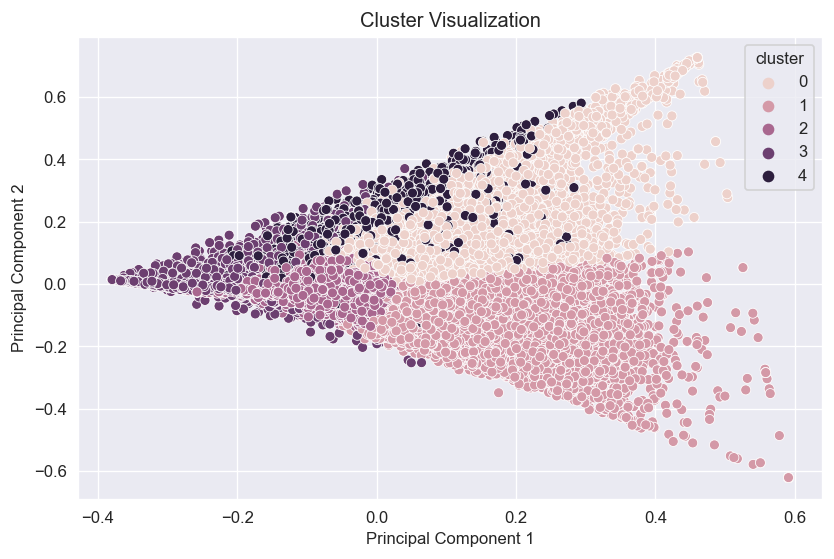

In [18]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

In [19]:
cross_df['cluster'] = c_preds
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,8,0,0,0,0,0,2,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,9,33,0,0,0,0,1,0,0,0,12,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,10,0,0,0,0,0,0,0,3,0,1,0,0,5,0,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,5,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,5,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,2
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,1,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1


In [20]:
#Top products per cluster

In [21]:
cluster1 = cross_df[cross_df.cluster == 0]
cluster1.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,9,33,0,0,0,0,1,0,0,0,12,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,10,0,0,0,0,0,0,0,3,0,1,0,0,5,0,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,5,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,5,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0,0
20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,0,6,1,1,0,0,0,0,0,0,0,0,0,0,1,11,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,21,0,1,0,0,0,0,0,0,24,0,0,0,0,5,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0,3,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,9,0
43,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,1,2,0,5,0,2,0,0,0,0,0,0,4,0,0,0,0,0,5,2,0,1,0,0,0,0,0,1,0,20,2,0,11,1,0,0,0,0,7,0,0,2,0,0,0,0,1,0,1,3,3,0,0,8,1,0,0,0,0,0,0,0,7,0,1,0,0,0,0,0,0,4,4,0,1,3,0,15,1,3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,6,0


In [22]:
cluster1.shape

(38498, 135)

In [23]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     35.699335
fresh vegetables                 15.152787
packaged vegetables fruits       12.176710
yogurt                            9.961297
milk                              5.985376
packaged cheese                   5.163645
soy lactosefree                   3.787963
water seltzer sparkling water     3.623669
bread                             3.215362
chips pretzels                    3.146865
dtype: float64

In [24]:
print("{cluster} results into {shapel} consumers having a very strong preference for water seltzer sparkling water aisle.".format(cluster="Cluster 1", shapel= cluster1.shape[0]))





Cluster 1 results into 38498 consumers having a very strong preference for water seltzer sparkling water aisle.


In [25]:
cluster2 = cross_df[cross_df.cluster == 1]
cluster2.shape

(55547, 135)

In [26]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 37.065980
fresh fruits                     21.680361
packaged vegetables fruits       11.994059
yogurt                            6.129296
packaged cheese                   5.003168
fresh herbs                       4.155094
milk                              3.987218
soy lactosefree                   3.701370
frozen produce                    3.296596
water seltzer sparkling water     3.076278
dtype: float64

In [27]:
print("{cluster} results into {shapel} consumers having a very strong preference for fresh fruits followed by vegetables.".format(cluster="Cluster 2", shapel= cluster2.shape[0]))



Cluster 2 results into 55547 consumers having a very strong preference for fresh fruits followed by vegetables.


In [28]:
cluster3 = cross_df[cross_df.cluster == 2]
cluster3.shape

(98800, 135)

In [29]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     9.705314
fresh vegetables                 7.550567
yogurt                           7.190628
packaged vegetables fruits       5.970547
packaged cheese                  4.920445
chips pretzels                   4.480010
milk                             4.241670
water seltzer sparkling water    4.089879
refrigerated                     3.252814
ice cream ice                    3.098603
dtype: float64

In [30]:
print("{cluster} results into {shapel} consumers having a very strong preference for fresh vegetables followed by fruits.".format(cluster="Cluster 3", shapel= cluster3.shape[0]))



Cluster 3 results into 98800 consumers having a very strong preference for fresh vegetables followed by fruits.


In [31]:
cluster4 = cross_df[cross_df.cluster == 3]
cluster4.shape

(5414, 135)

In [32]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    20.950683
fresh fruits                      3.336535
soft drinks                       2.800702
yogurt                            2.254895
energy granola bars               1.557074
chips pretzels                    1.346694
milk                              1.327484
tea                               1.327115
packaged vegetables fruits        1.251201
soy lactosefree                   1.082564
dtype: float64

In [33]:
print("{cluster} results into {shapel} consumers having a very strong preference for packaged produce and fresh fruits.".format(cluster="Cluster 4", shapel= cluster4.shape[0]))



Cluster 4 results into 5414 consumers having a very strong preference for packaged produce and fresh fruits.


In [34]:
cluster5 = cross_df[cross_df.cluster == 4]
cluster5.shape

(7950, 135)

In [35]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
packaged produce                 18.353962
fresh fruits                     10.893962
packaged vegetables fruits        4.230943
fresh vegetables                  3.098994
water seltzer sparkling water     1.716226
milk                              1.616101
packaged cheese                   1.544403
frozen produce                    1.147044
chips pretzels                    1.141132
nuts seeds dried fruit            1.032327
dtype: float64

In [36]:
print("{cluster} results into {shapel} consumers having a very strong preference for fresh fruits and vegetables.".format(cluster="Cluster 5", shapel= cluster5.shape[0]))



Cluster 5 results into 7950 consumers having a very strong preference for fresh fruits and vegetables.
